In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import os, sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import pandas
import anndata
import tangram

# from IPython.display import Audio
# tada = 'C://Users/stephanies/tada.mp3'

from celltype_mapping import TangramMapping, bin_gene_table, convert_to_anndata

In [3]:
sys.path.append(os.getcwd() + '/../gene_panel_selection')
sys.path.append(os.getcwd() + '/../segmentation')

from segmentation import SpotTable
from gene_panel_selection import ExpressionDataset

Relevant code for loading raw(ish) data and convering to anndata for use with tangram. Suggest that these data be saved for later loading if they will be reused as they are large and this takes some time. If you've already done this skip down...

In [4]:
# base network data path
data_path = '//allen/programs/celltypes/workgroups/rnaseqanalysis'

# raw spatial data

sp_data_path = '../../../data/merscope_pilot/1191380492'
sp_csv_file = sp_data_path + '/detected_transcripts.csv'
sp_cache_file = sp_data_path + '/detected_transcripts.npz'

# spatial AnnData file
sp_anndata_file = sp_data_path + '/macaque-merscope-1191380492.h5ad'

# raw single cell data
sc_data_path = data_path + '/Nik/Analyses_for_great_apes_paper/Shiny_obj_final/rhesus'
rnaSeq_data_file = sc_data_path + '/data.feather'
rnaSeq_anno_file = sc_data_path + '/anno.feather'

# single cell AnnData file
sc_anndata_file = data_path + '/NHP_spatial/snRNAseq_data/macaque_MTG_logcpm.h5ad'

# path for storing tangram mapping
tg_mapping_path = sp_data_path + '/mapping'

Read raw SC expression data

In [ ]:
expression = pd.read_feather(rnaSeq_data_file)
expression.set_index('sample_id', inplace=True)
annotations = pd.read_feather(rnaSeq_anno_file)
annotations.set_index('sample_id', inplace=True)

exp_data = ExpressionDataset(
    expression_data=expression,  
    expression_type='logcpm',
    annotation_data=annotations,
)

Read raw spatial data

In [10]:
cell_by_gene = pandas.read_csv('../../../data/merscope_pilot/1191380492/cell_by_gene.csv')
cell_meta = pandas.read_csv('../../../data/merscope_pilot/1191380492/cell_metadata.csv')
cell_meta.rename(columns={'center_x': 'x', 'center_y': 'y'}, inplace=True)

In [11]:
cell_meta.head()

Unnamed: 0  fov       volume           x  \
0    1849101426878809509770556837196097032    0  1362.597299  113.578200   
1  201168326311275598684414317623938319497    0    18.655111  141.820201   
2  229624050559731701691561312373385341414    0   844.120808  124.756201   
3  270684192156742006402279999613140539716    0   426.119476  261.970204   
4    2945382571653404687152488603491190845    0   769.644706  208.078203   

             y       min_x       max_x        min_y        max_y  
0  3295.735479   98.188200  128.968201  3287.311479  3304.159479  
1  3283.369479  139.660201  143.980201  3282.127479  3284.611479  
2  3430.087482  115.792200  133.720201  3420.907482  3439.267483  
3  3286.879479  253.708204  270.232204  3281.479479  3292.279479  
4  3305.995479  198.520203  217.636203  3298.111479  3313.879479

In [35]:
# Convert expression matrix to AnnData
ad_sp = anndata.AnnData(cell_by_gene, obs=cell_meta)
# ad_sp.obs_names = cell_by_gene.index.astype('str')
# ad_sp.var_names = cell_by_gene.columns
ad_sp

AnnData object with n_obs × n_vars = 117888 × 551
    obs: 'Unnamed: 0', 'fov', 'volume', 'x', 'y', 'min_x', 'max_x', 'min_y', 'max_y'

In [36]:
ad_sp.write_h5ad(sp_anndata_file)

If you already have data saved out TangramMapping class can be instantiated from those files

In [37]:
meta = {
    'snRNAseq': 'logcpm',
    'snRNAseq_region': 'MTG',
    'spatial_method': 'merfish',
    'spatial_region': 'MTG'
}
tg_map = TangramMapping(
    sc_data=sc_anndata_file, 
    sp_data=sp_anndata_file, 
    meta=meta)

In [38]:
tg_map.meta

{'snRNAseq': 'logcpm',
 'snRNAseq_region': 'MTG',
 'spatial_method': 'merfish',
 'spatial_region': 'MTG'}

Select your training genes for Tangram

In [39]:
## select marker genes

neuron_marker_genes = pd.read_csv(data_path + '/NHP_spatial/snRNAseq_data/macaque_subclass_roc_markers.csv')
print(f'subclass marker genes: {len(neuron_marker_genes)}')
glia_marker_genes = pd.read_csv(data_path + '/NHP_spatial/snRNAseq_data/macaque_glia_roc_markers.csv')
print(f'glial marker genes: {len(glia_marker_genes)}')
marker_genes_df = neuron_marker_genes.append(glia_marker_genes)
marker_genes = marker_genes_df['gene'].to_list()
print(f'total marker genes: {len(marker_genes)}')

subclass marker genes: 1856
glial marker genes: 1781
total marker genes: 3637


In [40]:
marker_genes_df.head()

Unnamed: 0  myAUC   avg_diff  power  avg_logFC  pct.1  pct.2 cluster  \
0     SEMA3E  0.968   8.481257  0.936   8.481257  0.996  0.225   L6 CT   
1       NRP1  0.916  18.626423  0.832  18.626423  0.891  0.129   L6 CT   
2     GPR155  0.910  15.428360  0.820  15.428360  0.989  0.746   L6 CT   
3      RXFP1  0.910  15.354289  0.820  15.354289  0.978  0.393   L6 CT   
4      TRPM3  0.907   0.481257  0.814   0.481257  0.958  0.454   L6 CT   

     gene  avg_log2FC  
0  SEMA3E         NaN  
1    NRP1         NaN  
2  GPR155         NaN  
3   RXFP1         NaN  
4   TRPM3         NaN

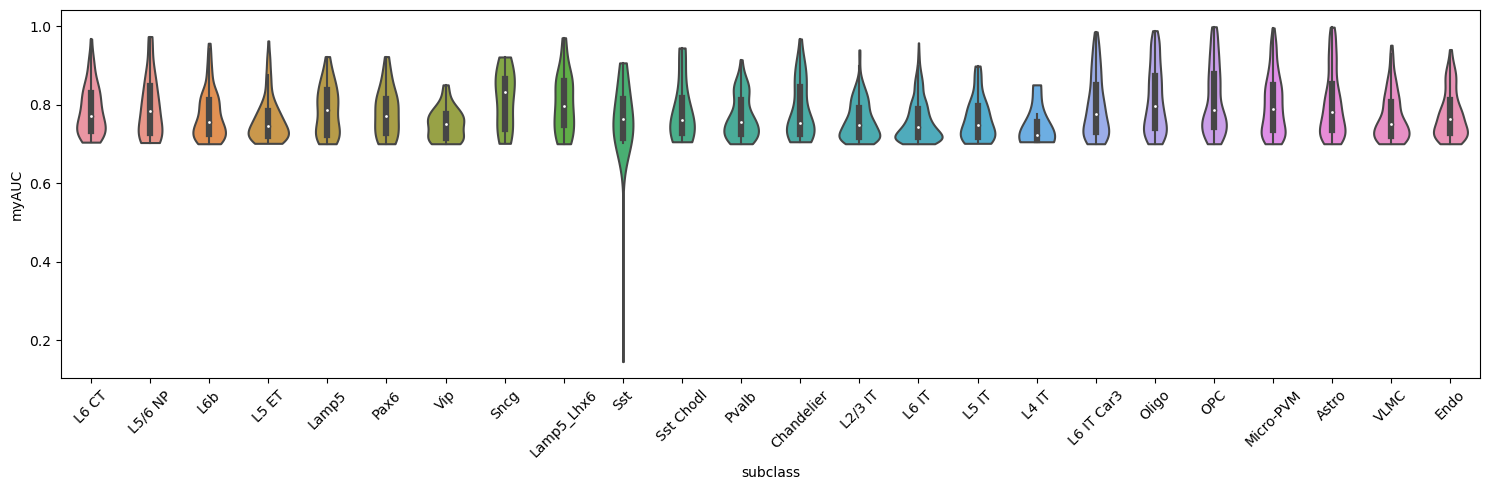

In [41]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.violinplot(data=marker_genes_df, x='cluster', y='myAUC', ax=ax, cut=0)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_xlabel('subclass')
plt.tight_layout()

In [42]:
# reduce to marker genes with AUC above median value per cluster
marker_medians = marker_genes_df.groupby('cluster').median()
marker_genes_reduced = None
for cluster in marker_genes_df['cluster'].unique():
    thresh = marker_medians.loc[cluster]['myAUC']
    gene_filter = marker_genes_df[(marker_genes_df['cluster']==cluster) & (marker_genes_df['myAUC']>thresh)]
    if marker_genes_reduced is None:
        marker_genes_reduced = gene_filter
    else:
        marker_genes_reduced = marker_genes_reduced.append(gene_filter)
        
gene_list = marker_genes_reduced['gene'].tolist()

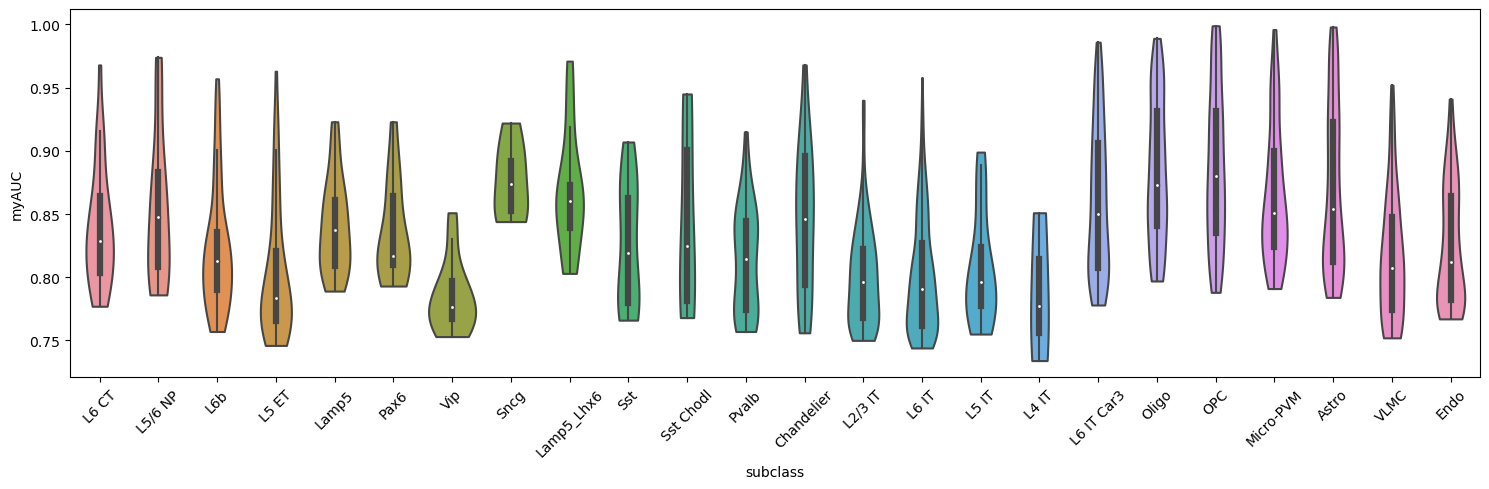

In [43]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.violinplot(data=marker_genes_reduced, x='cluster', y='myAUC', ax=ax, cut=0)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_xlabel('subclass')
plt.tight_layout()

In [44]:
tg_map.set_training_genes(gene_list, meta={'training_genes': 'subclass RNAseq markers above median ROC'})
#Audio(tada, autoplay=True)

starting with 1809 training genes..


INFO:root:292 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:490 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [45]:
# run mapping with default settings:
# device='cpu', mode='clusters', cluster_label='subclass'

tg_map.mapping()
#Audio(tada, autoplay=True)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 292 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.323, KL reg: 0.000
Score: 0.751, KL reg: 0.000
Score: 0.753, KL reg: 0.000
Score: 0.753, KL reg: 0.000
Score: 0.754, KL reg: 0.000
Score: 0.754, KL reg: 0.000
Score: 0.754, KL reg: 0.000
Score: 0.754, KL reg: 0.000
Score: 0.754, KL reg: 0.000
Score: 0.754, KL reg: 0.000


INFO:root:Saving results..


In [46]:
if not os.path.exists(tg_mapping_path):
    os.mkdir(tg_mapping_path)
tg_map.save_mapping(save_path=tg_mapping_path)
#Audio(tada, autoplay=True)

analysis UID: 1664878951.791


In [5]:
tg_map = TangramMapping.load_from_timestamp(directory=tg_mapping_path, timestamp='1664878951.791')
tg_map.meta

{'snRNAseq': 'logcpm',
 'snRNAseq_region': 'MTG',
 'spatial_method': 'merfish',
 'spatial_region': 'MTG',
 'training_genes': 'subclass RNAseq markers above median ROC',
 'mode': 'clusters',
 'cluster_label': 'subclass'}

In [6]:
tg_map.ad_sp.obs

Unnamed: 0   fov       volume  \
0         1849101426878809509770556837196097032     0  1362.597299   
1       201168326311275598684414317623938319497     0    18.655111   
2       229624050559731701691561312373385341414     0   844.120808   
3       270684192156742006402279999613140539716     0   426.119476   
4         2945382571653404687152488603491190845     0   769.644706   
...                                         ...   ...          ...   
117883  312515433784251493616606553558195065974  2076   884.702782   
117884  327113600014761228903840463765648862510  2076  1412.605243   
117885  331020021347933921241937494885524573087  2076  1155.085980   
117886   47287226756335193514624842854720841418  2076  1762.595245   
117887   71382807755638765344571420446605503202  2076    47.764082   

                  x            y        min_x        max_x        min_y  \
0        113.578200  3295.735479    98.188200   128.968201  3287.311479   
1        141.820201  3283.369479   139.660201   143.980201  3282.127479   
2        124.756201  3430.087482   115.792200   133.720201  3420.907482   
3        261.970204  3286.879479   253.708204   270.232204  3281.479479   
4        208.078203  3305.995479   198.520203   217.636203  3298.111479   
...             ...          ...          ...          ...          ...   
117883  9049.907763  9590.472800  9041.213763  9058.601763  9581.076799   
117884  9050.771763  9494.028797  9040.025763  9061.517763  9483.768797   
117885  9023.609762  9522.648798  9013.673762  9033.545763  9510.768798   
117886  8876.297759  9685.134802  8861.393758  8891.201759  9673.740802   
117887  9061.031763  9485.604797  9056.549763  9065.513764  9482.256797   

              max_y  uniform_density  rna_count_based_density  
0       3304.159479         0.000008                      0.0  
1       3284.611479         0.000008                      0.0  
2       3439.267483         0.000008                      0.0  
3       3292.279479         0.000008                      0.0  
4       3313.879479         0.000008                      0.0  
...             ...              ...                      ...  
117883  9599.868800         0.000008                      0.0  
117884  9504.288797         0.000008                      0.0  
117885  9534.528798         0.000008                      0.0  
117886  9696.528802         0.000008                      0.0  
117887  9488.952797         0.000008                      0.0  

[117888 rows x 11 columns]

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


Running core analysis set..
1) plot training scores of mapping
2) plot mapping probability at each spatial position for each cluster label
3) get and plot the maximum cluster label for each spatial position
4) predict spatial gene expression, plot canonical markers and histogram of scores
          score  is_training  sparsity_sp  sparsity_sc  sparsity_diff
cux2   0.876872         True     0.736767     0.524233       0.212534
rorb   0.869691         True     0.716502     0.620701       0.095801
lamp5  0.844945         True     0.811117     0.865741      -0.054623
grik1  0.750976         True     0.842605     0.335638       0.506967
pvalb  0.655048        False     0.894807     0.937685      -0.042878


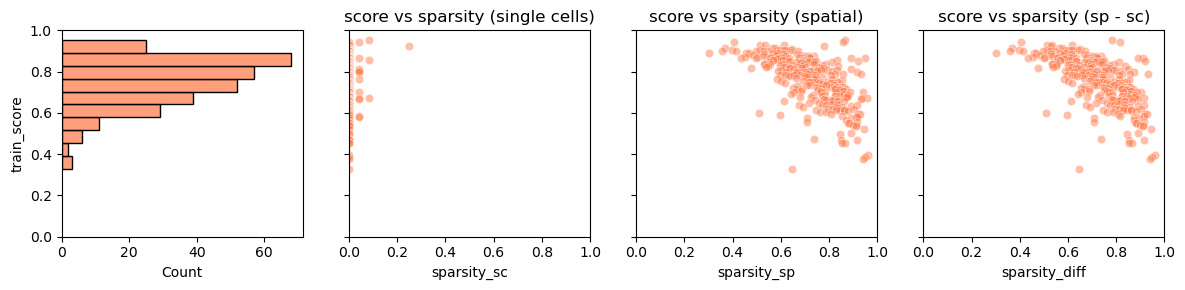

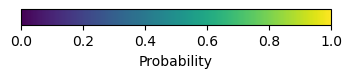

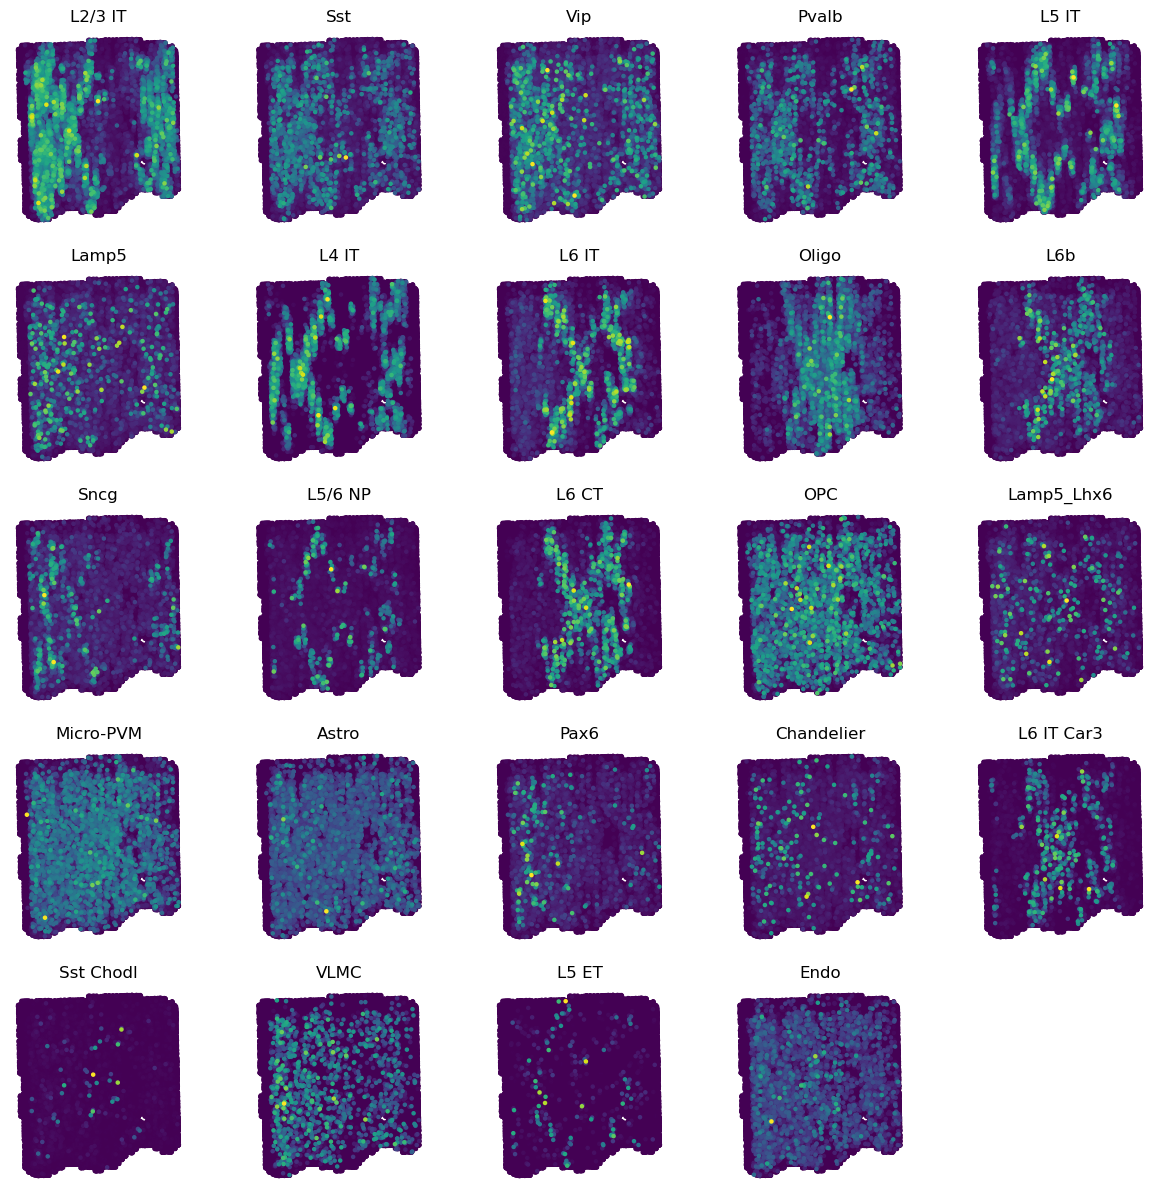

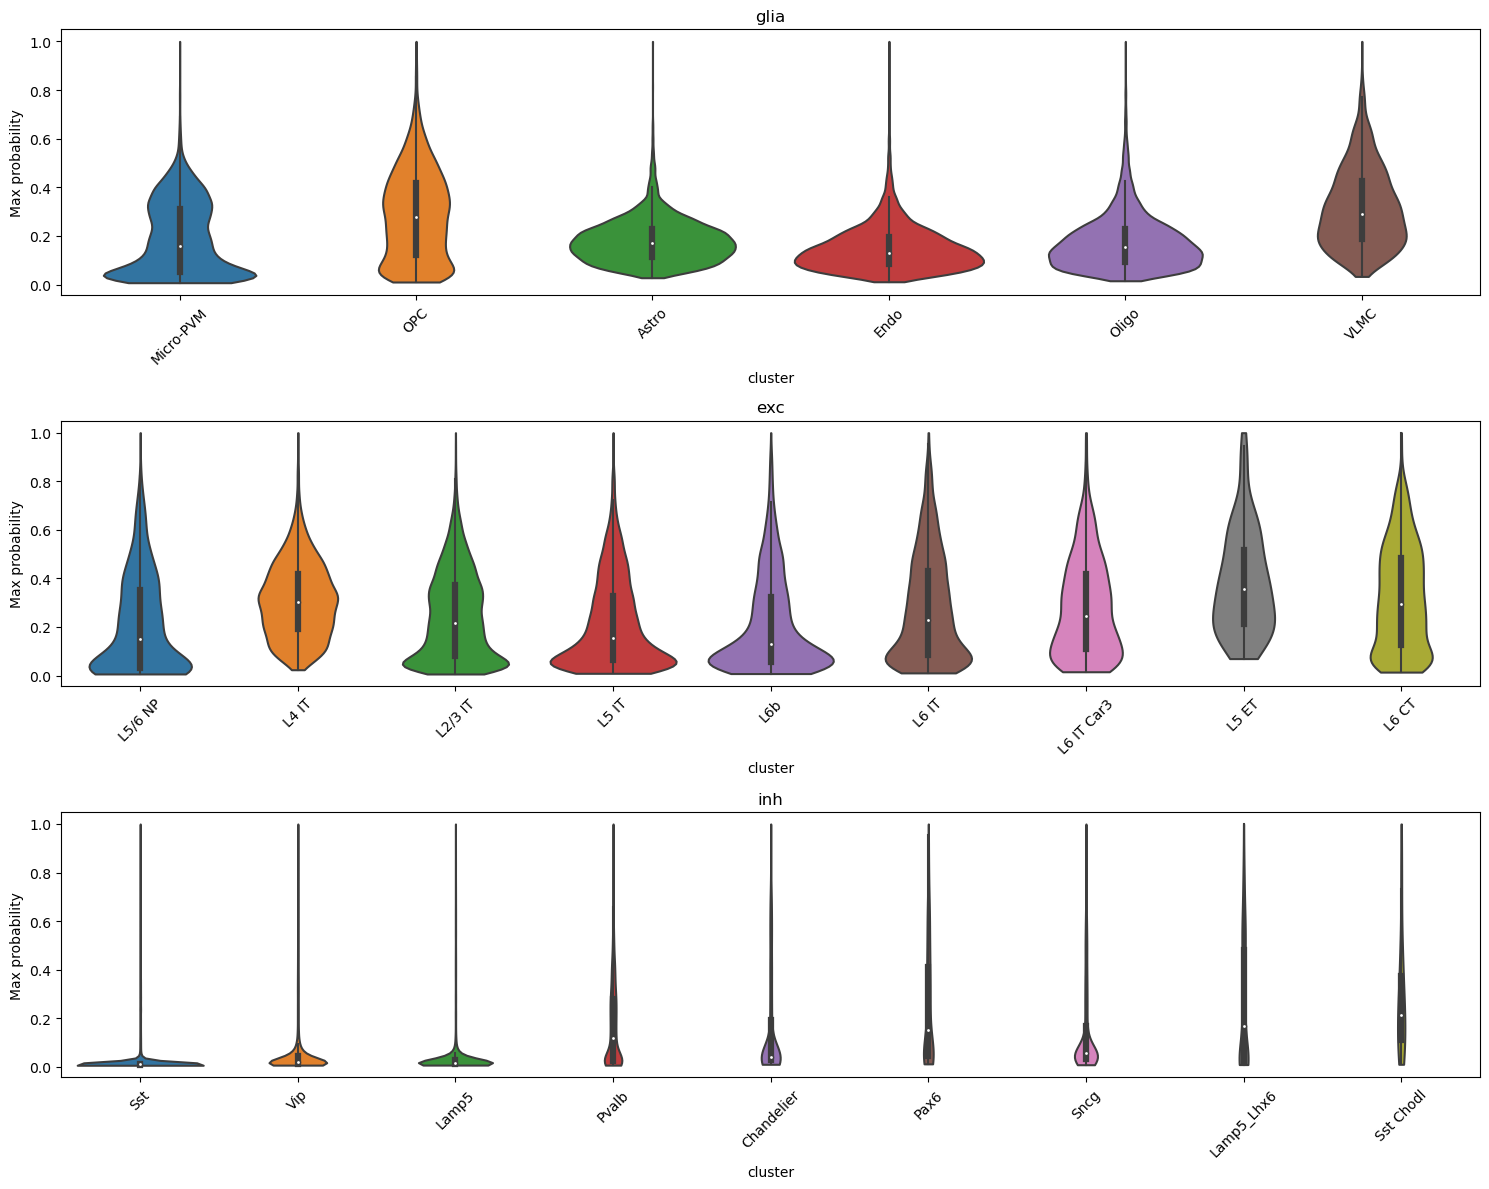

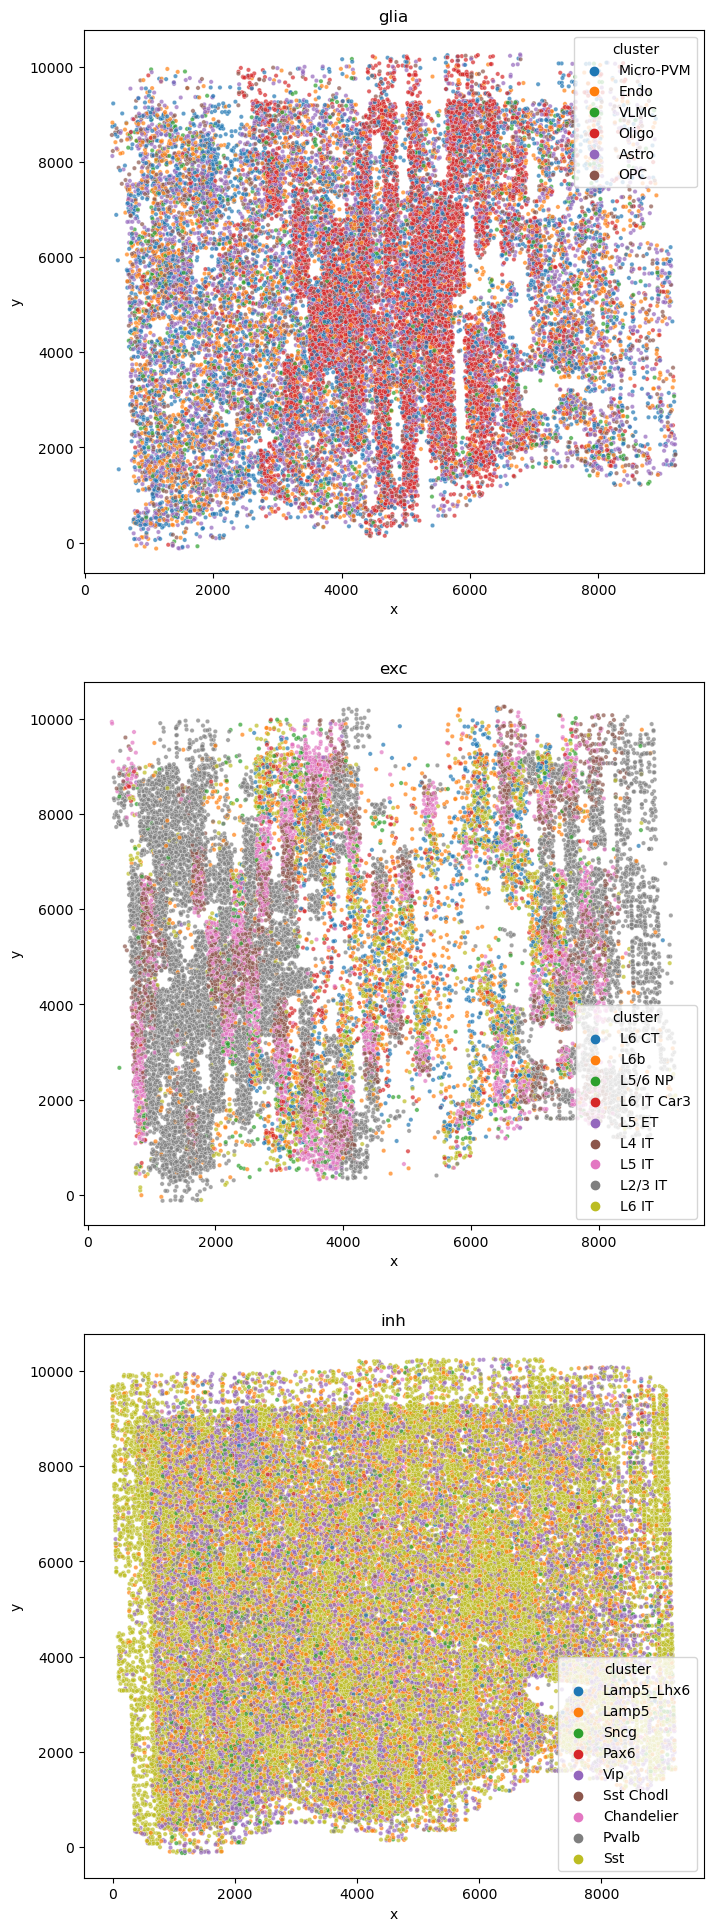

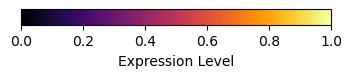

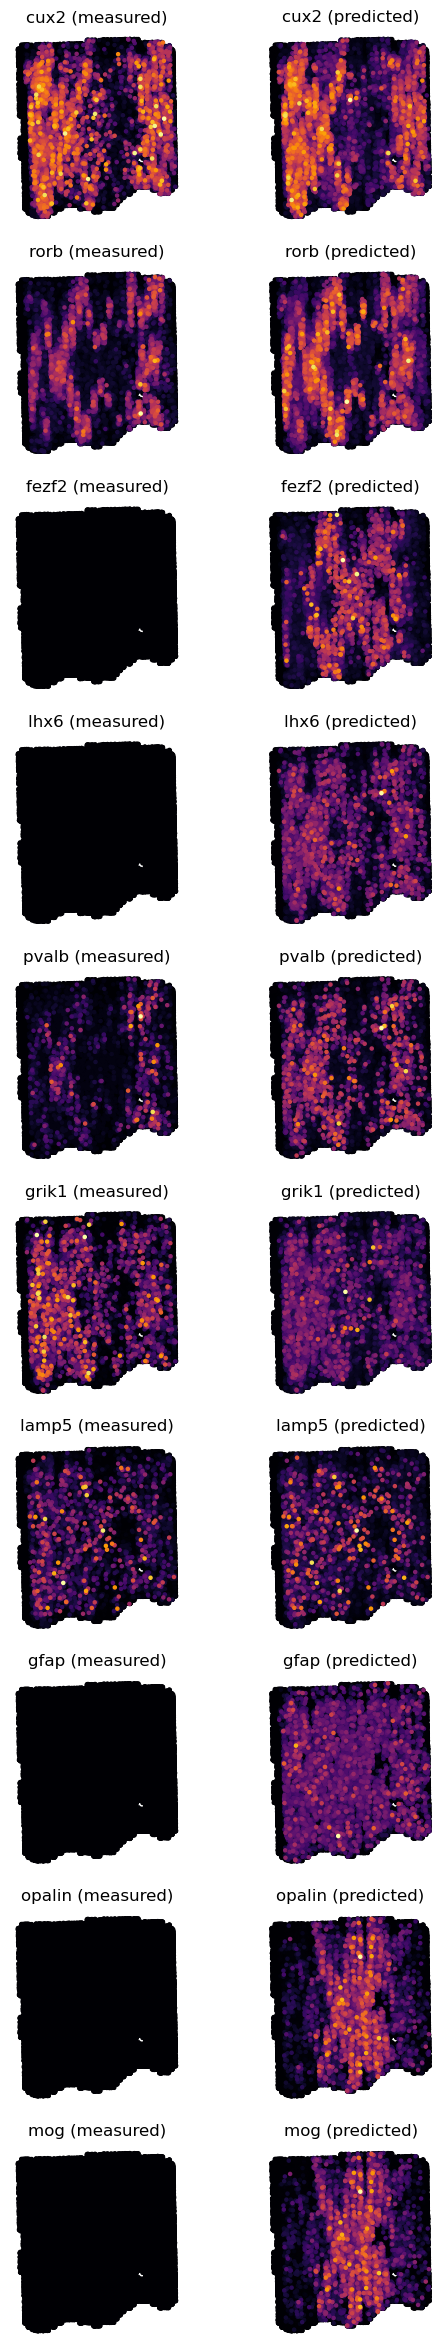

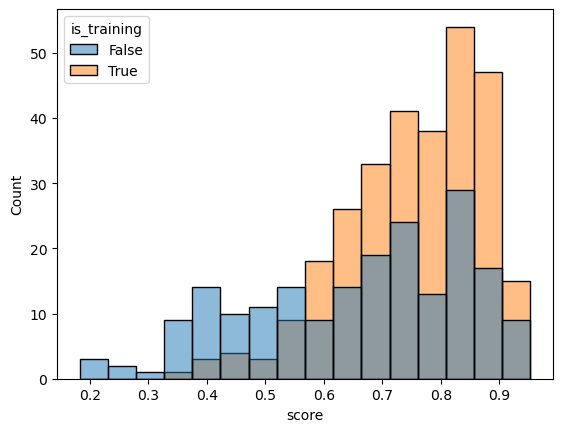

In [7]:
tg_map.evaluate_mapping()

<Figure size 640x480 with 0 Axes>

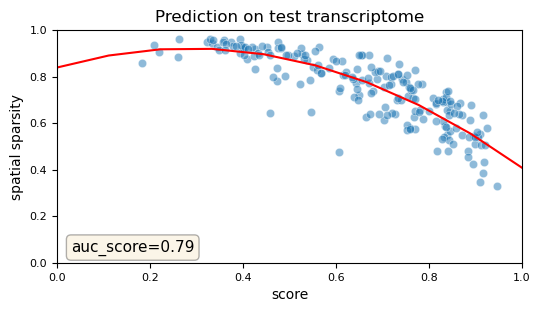

In [8]:
tangram.plot_auc(tg_map.spatial_score)

In [ ]:
tg_map.save_mapping(save_path=tg_mapping_path, file_name='evaluation', replace=True,)             
# Audio(tada, autoplay=True)

(0.0, 1.0)

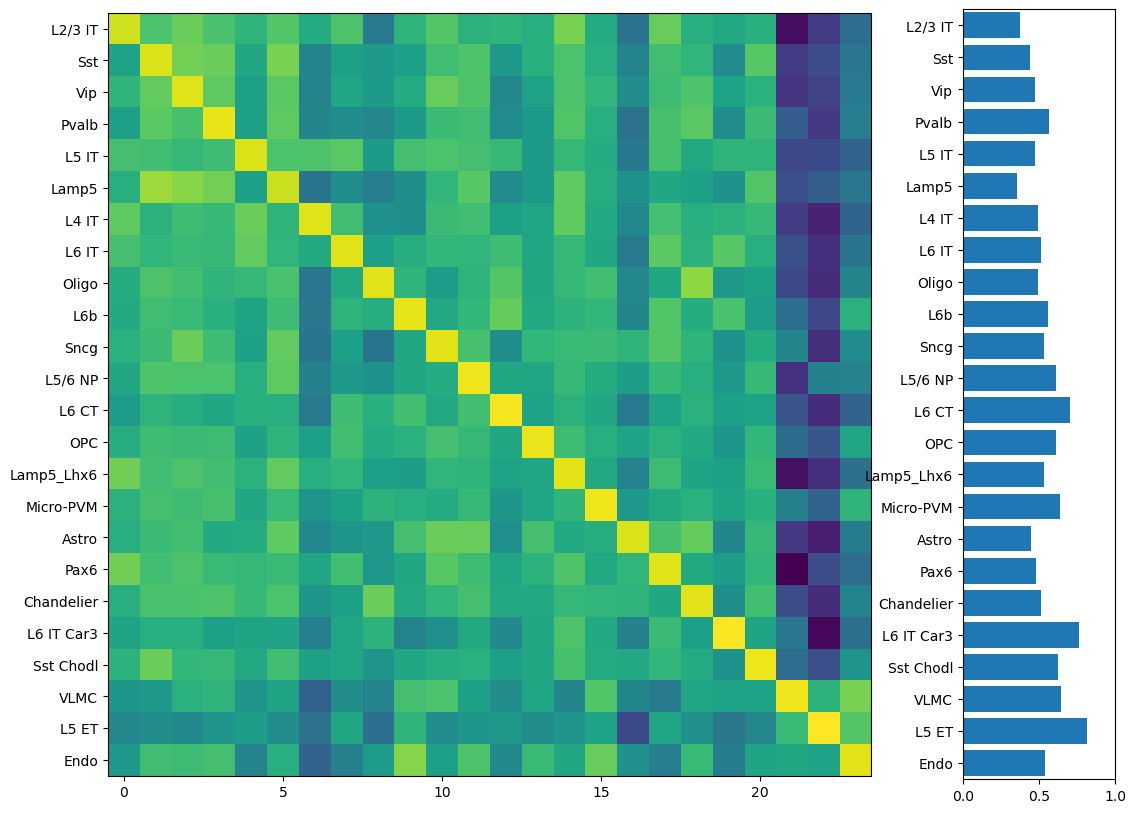

In [25]:
n_types = tg_map.ad_map.X.shape[0]
most_likely_type = tg_map.ad_map.X.argmax(axis=0)

conf_matrix = [[] for i in range(n_types)]
for i in range(tg_map.ad_map.X.shape[1]):
    conf_matrix[most_likely_type[i]].append(tg_map.ad_map.X[:, i])
for i in range(n_types):
    conf_matrix[i] = np.stack(conf_matrix[i], axis=1).sum(axis=1)
    conf_matrix[i] /= conf_matrix[i].sum()
conf_matrix = np.array(conf_matrix)

diff = np.diag(conf_matrix) / conf_matrix.sum(axis=1)



import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(13, 10))

gs = plt.GridSpec(1, 2, width_ratios=[5,1])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharey=ax1)

# fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax1.imshow(np.log(conf_matrix))
ax1.set_yticks(np.arange(n_types))
ax1.set_yticklabels(tg_map.ad_map.obs['subclass']);

ax2.barh(np.arange(n_types), diff)
ax2.set_yticks(np.arange(n_types))
ax2.set_yticklabels(tg_map.ad_map.obs['subclass']);
ax2.set_xlim(0, 1)

